# Exercise: Spectral calibration and sampling

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise is decievingly simple looking, but involves a range of skills such as accurate resampling, understanding of Beer-Lambert transmission, model optimization and fitting.  We will perform a wavelength calibration based on an example transmittance curve from the ATREM radiative transfer model.  I have provided top-of-atmosphere reflectances over Ivanpah playa, a smooth target, to get us started.  We first load the relevant files.  Note that wavelength data is supplied at extremely high spectral resolution.  Plot it!

In [1]:
import scipy as s
import scipy.ndimage.filters as filters
from scipy.linalg import norm, inv
import pylab as plt
import figure_style
from scipy.optimize import minimize

# Load the target 
wl = s.loadtxt('data/initial_wavelengths.txt') / 1000.0 # translate to microns
fwhm = s.loadtxt('data/initial_fwhm.txt') / 1000.0 # translate to microns
toa = s.loadtxt('data/20150927_Ivanpah_v1i_toa_1.txt')
transmission = s.loadtxt('data/TRAN_STD_RES_0p1nm_3p0H2O')[:,1]
wl_transmission = s.loadtxt('data/TRAN_STD_RES_0p1nm_3p0H2O')[:,0] / 1000.0 # translate to microns

Note that wavelength data is supplied at extremely high spectral resolution. Plot it and save to a file!  We boost the default figure size for more resolution.

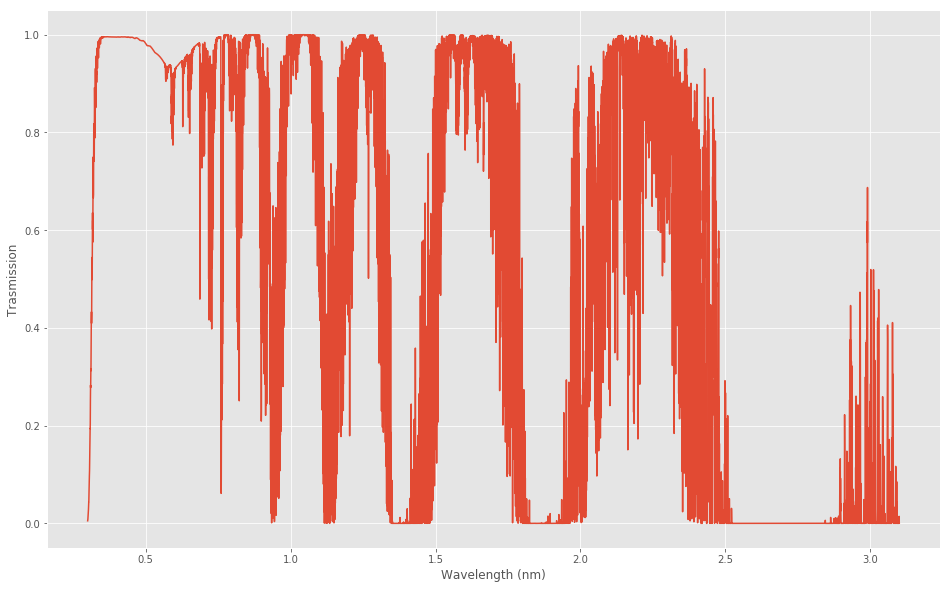

In [2]:
from IPython.core.pylabtools import figsize
figsize(16,16/1.618)

plt.plot(wl_transmission, transmission)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Trasmission');
plt.savefig('results/transmission.png');

We will define three critical helper functions for this analysis: 
1. A spectral response function that can be used to represent the response of a specific channel over a vector of wavelengths. 
2. A forward model that computes a synthetic spectrum with a linear continuum attenuated by the absorption feature, with five free parameters: the continuum offset and slope, the absorption feature depth, the wavelength shift, and a scaling factor on the original spectral full width at half maximum.  
3. An error function to be minimized, which calculates the mismatch between the instrument measurement and the model.

In [3]:
# Spectral response function, calculated at a range of locations x, for a multivariate Gaussian with mean mu and standard deviation sigma
def srf(x, mu, sigma):
     u = (x-mu)/abs(sigma)
     y = (1.0/(s.sqrt(2.0*s.pi)*abs(sigma)))*s.exp(-u*u/2.0)
     return y/y.sum()

# Fit the TOA spectrum and model 
# uses a state vector x where:
#  x[0] = vertical offset 
#  x[1] = slope 
#  x[2] = depth of absorption feature [0,1] 
#  x[3] = wavelength shift 
#  x[4] = multiplier factor on FWHM
def synth_spectrum(x, toa, toa_wl, model, model_wl, fwhm, b):
    offset, slope, depth, shift, dfwhm = x
    toa_wl_new = (toa_wl+shift)
    use = s.logical_and(toa_wl_new>=b[0], toa_wl_new<=b[1])
    wl = toa_wl_new[use]
    wdelta = model_wl[1]-model_wl[0]
    sigma = fwhm*dfwhm/2.3548/wdelta
    if sigma<=1.0:
        sigma=1.0
    
    # create spectrum, apply instrument response function and resample
    model = s.exp(-depth*s.log(model)) * offset+slope*(model_wl-b[0])
    model_smooth = filters.gaussian_filter1d(model, sigma)
    model_out = s.interp(wl, model_wl, model_smooth)
    return wl, toa[use], model_out

# RMSE error 
def err(x, toa, toa_wl, model, model_wl, fwhm, b):
        wl,obs,mdl = synth_spectrum(x, toa, toa_wl, model, model_wl, fwhm, b)
        er = s.sqrt(pow(mdl-obs,2).mean())
        return er


Pick a relevant atmospheric feature window, such as the oxygen A band at 0.75 microns. Find appropriate continuum limits for this feature, and then define an initial state vector solution that puts you in the right ballpark for the free parameters.  Then, find the state vector to minimize error using a standard nonlinear optimization approach such as scipy's optimize.minimize()  

In [4]:
# Do the calibration

lims = (0.74,0.78)
args = toa, wl,  transmission, wl_transmission, fwhm[0], lims
x_initial = 0.45,0,-0.8,0,0.9
res = minimize(err, x_initial, args=args, method='Nelder-Mead', options={'maxiter':100})
wln, meas, mdl = synth_spectrum(res.x, toa, wl, transmission, wl_transmission, fwhm[0], lims)


/Users/drt/src/anaconda37/anaconda3/lib/python3.7/site-packages/numpy/lib/scimath.py:274: RuntimeWarning: divide by zero encountered in log
  return nx.log(x)


Plot the resulting solution against the measurement in the fitting window.

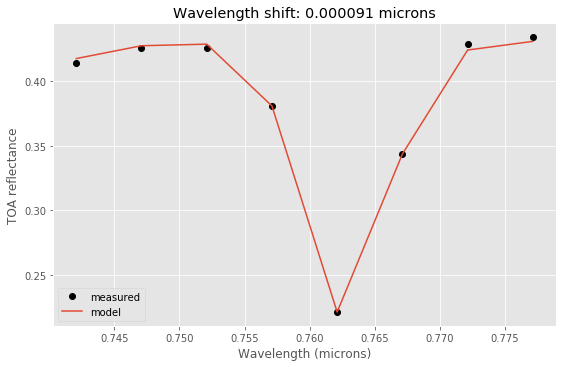

In [5]:
figsize(9,9/1.618)
plt.plot(wln,meas,'ko')
plt.plot(wln,mdl)
plt.legend(('measured','model'))
plt.title('Wavelength shift: %f microns'%res.x[3])
plt.xlabel('Wavelength (microns)')
plt.ylabel('TOA reflectance');
plt.savefig('results/shift.png')

<b> Question 1: </b> What is the wavelength calibration for the instrument?

<b> Question 2: </b> Is there a way of quantifying how accurate this method can be?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.